In [86]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import PercentFormatter

from score import get_scores

NAME_WIDTH = 0.4
NUM_COLUMNS = 5
others_width = (1 - NAME_WIDTH) / (NUM_COLUMNS - 1)

outputs = Path("../data/final")

ref = {
    "test": Path("../data/SHROOM_test-labeled"),
    "val": Path("../data/SHROOM_dev-v2"),
}

tracks = ["aware", "agnostic"]
split = "test"

In [2]:
track = "aware"     
files = outputs.glob(f"**/{split}*{track}*.json")

scores = get_scores(files, ref[split], is_val=split == "val")

df_a = pd.DataFrame(scores).T
df_a.columns = ["Accuracy","Correlation"]

In [3]:
track = "agnostic"     
files = outputs.glob(f"**/{split}*{track}*.json")

scores = get_scores(files, ref[split], is_val=split == "val")

df_ag = pd.DataFrame(scores).T
df_ag.columns = ["Accuracy","Correlation"]

In [70]:
single = ["levenshtein","paragram","vectara-finetuned-on-valset","hidden-states","attention-flow"] 
ensemble = ["logreg","metamodel-linearreg-probs","probability-fusion","vote"]
order = single + ensemble

In [87]:
df = pd.concat([df_ag,df_a],axis=1,keys=["Model-Agnostic","Model-Aware"])
arrays = [
    ["single"] * len(single) + ["ensemble"] * len(ensemble),
    order
]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)
df = df.reindex(order)

In [88]:
df

Model-Agnostic             Model-Aware            
                                  Accuracy Correlation    Accuracy Correlation
levenshtein                       0.663333    0.362287    0.711333    0.417967
paragram                          0.643333    0.355100    0.685333    0.378913
vectara-finetuned-on-valset       0.808667    0.722567    0.806000    0.707192
hidden-states                          NaN         NaN    0.593333    0.136995
attention-flow                         NaN         NaN    0.610000    0.245289
logreg                            0.801333    0.665318    0.800667    0.635767
metamodel-linearreg-probs         0.816667    0.737138    0.800667    0.712133
probability-fusion                0.793333    0.673285    0.783333    0.653506
vote                              0.734667    0.596796    0.756000    0.586733

In [96]:
baseline = 0.6966666666666667,0.40298808914014683,0.7453333333333333,0.48788676869571396

In [97]:
df.loc["baseline"] = baseline

In [99]:
df.style.set_table_styles(
    [
        {"selector": "toprule", "props": ":hline;"},
        {"selector": "midrule", "props": ":hline;"},
        {"selector": "bottomrule", "props": ":hline;"},
    ],
    overwrite=False,
).format(precision=3, na_rep="-").format_index(
    escape="latex", axis=0
).highlight_max(
    # subset=["Accuracy"],
    axis=0,
    props='textit:--rwrap; textbf:--rwrap;'
).to_latex(
    Path(f"tables/final.tex"),
    clines="all;data",
    caption=f"Results for all models",
    label=f"results",
    column_format=f"|p{{{NAME_WIDTH}\linewidth}}" + f"|R{{{others_width:.3f}\linewidth}}" * (NUM_COLUMNS - 1) + "|",
    position_float="centering",
    multirow_align="t", 
    multicol_align="r"
)


# Some other experiments

In [159]:
hspath = "../data/final/hidden_states/test.model-aware.json"
df_hs = pd.read_json(hspath)
ground_truth_aware_path = "../data/SHROOM_test-labeled/test.model-aware.json"
df_gt = pd.read_json(ground_truth_aware_path)
df_hs = df_hs.set_index("id").sort_index()
df_gt = df_gt.set_index("id").sort_index()

In [166]:
df_gt[df_hs["label"] != df_gt["label"]]["task"].value_counts() / df_gt["task"].value_counts()

task
DM    0.475089
MT    0.394316
PG    0.322667
Name: count, dtype: float64

In [41]:

# Load metamodel files (assuming your file paths are correct)
metamodel_agnostic_path = "../data/final/metamodel_linearreg_probs/test.model-agnostic.json"
metamodel_aware_path = "../data/final/metamodel_linearreg_probs/test.model-aware.json"

with open(metamodel_agnostic_path, 'r') as file:
    metamodel_agnostic = json.load(file)

with open(metamodel_aware_path, 'r') as file:
    metamodel_aware = json.load(file)

# Combine metamodels
metamodel = metamodel_agnostic + metamodel_aware

# Load ground truth files (assuming your file paths are correct)
ground_truth_agnostic_path = "../data/SHROOM_test-labeled/test.model-agnostic.json"
ground_truth_aware_path = "../data/SHROOM_test-labeled/test.model-aware.json"

with open(ground_truth_agnostic_path, 'r') as file:
    ground_truth_agnostic = json.load(file)

with open(ground_truth_aware_path, 'r') as file:
    ground_truth_aware = json.load(file)

# Combine ground truths
ground_truth = ground_truth_agnostic + ground_truth_aware

# Convert to pandas DataFrame for easier manipulation
df_metamodel = pd.DataFrame(metamodel)
df_ground_truth = pd.DataFrame(ground_truth)

# Merge DataFrames on 'id'
merged_df = pd.merge(df_metamodel, df_ground_truth, on='id', suffixes=('_metamodel', '_ground_truth'))


merged_df

,id,p(Hallucination)_metamodel,label_metamodel,src,tgt,hyp,task,labels,label_ground_truth,p(Hallucination)_ground_truth
0,1,0.253867,Not Hallucination,"Ты удивишься, если я скажу, что на самом деле ...",Would you be surprised if I told you my name i...,You're gonna be surprised if I say my real nam...,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.0
1,2,0.499645,Not Hallucination,Еды будет полно.,There will be plenty of food.,The food will be full.,MT,"[Hallucination, Not Hallucination, Hallucinati...",Hallucination,0.8
2,3,0.152708,Not Hallucination,"Думаете, Том будет меня ждать?",Do you think that Tom will wait for me?,You think Tom's gonna wait for me?,MT,"[Not Hallucination, Not Hallucination, Not Hal...",Not Hallucination,0.2
3,6,0.888395,Hallucination,Два брата довольно разные.,The two brothers are pretty different.,There's a lot of friends.,MT,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,1.0
4,7,0.414399,Not Hallucination,<define> Infradiaphragmatic </define> intra- a...,(medicine) Below the diaphragm.,(anatomy) Relating to the diaphragm.,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8
...,...,...,...,...,...,...,...,...,...,...
2995,2988,0.793009,Hallucination,നിങ്ങൾക്ക് ചെറുതും രുചികരവുമായ പേസ്ട്രികൾ വേണമ...,"If you want some small though rich pastries, t...","If you want small, tasty pastries, try calling...",MT,"[Hallucination, Hallucination, Not Hallucinati...",Hallucination,0.6
2996,2991,0.222953,Not Hallucination,It is one of the most badly governed countries...,,It is a bad country.,PG,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8
2997,2995,0.132708,Not Hallucination,This is not currently the case.,,There isn't currently a case of this.,PG,"[Hallucination, Hallucination, Not Hallucinati...",Not Hallucination,0.4
2998,2997,0.523742,Hallucination,Tom Stoppard secured his place on the theatric...,Full of sport ; playful,Characteristic of a game ; playful .,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,1.0


In [42]:
df_ground_truth['p(Hallucination)']

0       0.0
1       0.8
2       0.2
3       1.0
4       0.8
       ... 
2995    0.6
2996    0.8
2997    0.4
2998    1.0
2999    0.6
Name: p(Hallucination), Length: 3000, dtype: float64

In [43]:
merged_df[merged_df['label_metamodel'] != merged_df['label_ground_truth']]

,id,p(Hallucination)_metamodel,label_metamodel,src,tgt,hyp,task,labels,label_ground_truth,p(Hallucination)_ground_truth
1,2,0.499645,Not Hallucination,Еды будет полно.,There will be plenty of food.,The food will be full.,MT,"[Hallucination, Not Hallucination, Hallucinati...",Hallucination,0.8
4,7,0.414399,Not Hallucination,<define> Infradiaphragmatic </define> intra- a...,(medicine) Below the diaphragm.,(anatomy) Relating to the diaphragm.,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8
5,8,0.491704,Not Hallucination,Твои часы правильно идут?,Is your watch right?,Is your watch going well?,MT,"[Not Hallucination, Hallucination, Hallucinati...",Hallucination,0.6
10,18,0.425578,Not Hallucination,If you doubt that you 'll stick around at the ...,"(financial, intransitive) To become vested, to...","(finance, intransitive) To become vesting.",DM,"[Hallucination, Not Hallucination, Hallucinati...",Hallucination,0.6
16,26,0.406557,Not Hallucination,The momentary madness which infects bridge pla...,(uncountable) The game of duplicate bridge.,(card games) A card game in which two players ...,DM,"[Hallucination, Not Hallucination, Hallucinati...",Hallucination,0.8
...,...,...,...,...,...,...,...,...,...,...
2983,2966,0.472537,Not Hallucination,I want them aspiring to be scientists and engi...,One who plays basketball ; a basketballer .,A person who plays the ball .,DM,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,1.0
2991,2981,0.615799,Hallucination,The person suffering from a confusional state ...,Characterized by confusion .,Of or pertaining to confusion .,DM,"[Not Hallucination, Not Hallucination, Halluci...",Not Hallucination,0.4
2994,2986,0.726253,Hallucination,to remit the performance of an obligation,To refrain from exacting or enforcing .,To give a remittance to ; to discharge .,DM,"[Hallucination, Hallucination, Not Hallucinati...",Not Hallucination,0.4
2996,2991,0.222953,Not Hallucination,It is one of the most badly governed countries...,,It is a bad country.,PG,"[Hallucination, Hallucination, Hallucination, ...",Hallucination,0.8


In [44]:
# merged_df.groupby("label_ground_truth").apply(lambda x:x[])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


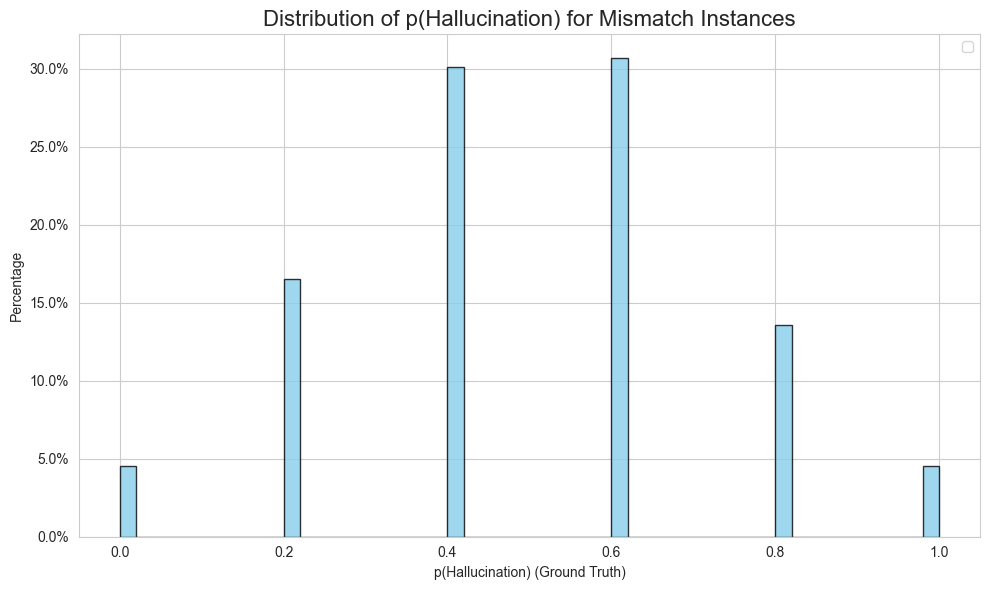

In [58]:
# Set a seaborn style for better aesthetics
import numpy as np


sns.set_style(style="whitegrid")

# Create a histogram with enhanced aesthetics for disagreed entries using Matplotlib
plt.figure(figsize=(10, 6))
# plt.hist(df_ground_truth['p(Hallucination)'], bins=50, color='salmon', edgecolor='salmon', label='Ground Truth p(Hallucination) Entries', alpha=0.5)
data = merged_df[merged_df['label_metamodel'] != merged_df['label_ground_truth']]['p(Hallucination)_ground_truth']
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# sns.displot(data, stat='percent', bins=50, ) # label='Ground Truth p(Hallucination) Entries in the Mismatch Instances',
plt.hist(data,
         bins=50, weights=np.ones(len(data)) / len(data), color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('p(Hallucination) (Ground Truth)')
plt.ylabel('Percentage')
plt.title('Distribution of p(Hallucination) for Mismatch Instances', fontsize=16)

plt.legend()
plt.tight_layout()
plt.show()
